# Load Data

In [13]:

import os
import zipfile
import glob
from PIL import Image

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
from google.colab import drive

drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/img_align_celeba.zip"
extract_dir = "/content/celeba"
img_size  = 64
batch_size = 128
num_workers = 6
os.makedirs(extract_dir, exist_ok=True)


def _has_any_image(root: Path) -> bool:
    exts = ("*.jpg", "*.jpeg", "*.png")
    for ext in exts:
        if any(root.rglob(ext)):
            return True
    return False

if not _has_any_image(Path(extract_dir)):
    assert os.path.exists(zip_path), f"No encuentro el zip en {zip_path}"
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(extract_dir)

exts = ("*.jpg", "*.jpeg", "*.png")
all_paths = []
for ext in exts:
    all_paths += list(Path(extract_dir).rglob(ext))

if not all_paths:
    raise FileNotFoundError(
        f"No encontré imágenes (.jpg/.jpeg/.png) tras extraer {zip_path}.\n"
        f"Revisa manualmente el contenido de {extract_dir}.")

class FlatImageDataset(Dataset):
    def __init__(self, paths, transform=None, skip_broken=True):
        self.paths = sorted(map(str, paths))
        self.transform = transform
        self.skip_broken = skip_broken

        if len(self.paths) == 0:
            raise FileNotFoundError("La lista de imágenes está vacía.")

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        try:
            img = Image.open(path).convert("RGB")
        except Exception as e:
            if self.skip_broken:
                return self.__getitem__((idx + 1) % len(self))
            else:
                raise e
        if self.transform:
            img = self.transform(img)
        return img, 0

transform = transforms.Compose([
    transforms.Resize(178, antialias=True),
    transforms.CenterCrop(178),
    transforms.Resize(img_size, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),])

dataset = FlatImageDataset(all_paths, transform=transform)
train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True)

print(f"[OK] Imágenes detectadas (recursivo): {len(dataset)}")
print(f"[OK] DataLoader listo: batch_size={batch_size}, img_size={img_size}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[OK] Imágenes detectadas (recursivo): 202599
[OK] DataLoader listo: batch_size=128, img_size=64


# Subset

In [17]:
import numpy as np
from torch.utils.data import Subset

N = min(100_000, len(dataset))

SEED_SUBSET = 2025
SEED_SHUFFLE = 1337

rng = np.random.default_rng(SEED_SUBSET)
subset_indices = rng.choice(len(dataset), size=N, replace=False)
subset = Subset(dataset, subset_indices.tolist())

g = torch.Generator()
g.manual_seed(SEED_SHUFFLE)

train_loader = DataLoader(
    subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    generator=g)

print(f"[OK] Subset listo: {len(subset)} imágenes (de {len(dataset)})")
print(f"[OK] DataLoader listo: batch_size={batch_size}, img_size={img_size}")

[OK] Subset listo: 100000 imágenes (de 202599)
[OK] DataLoader listo: batch_size=128, img_size=64


In [15]:

imgs, _ = next(iter(train_loader))
imgs.shape

torch.Size([128, 3, 64, 64])

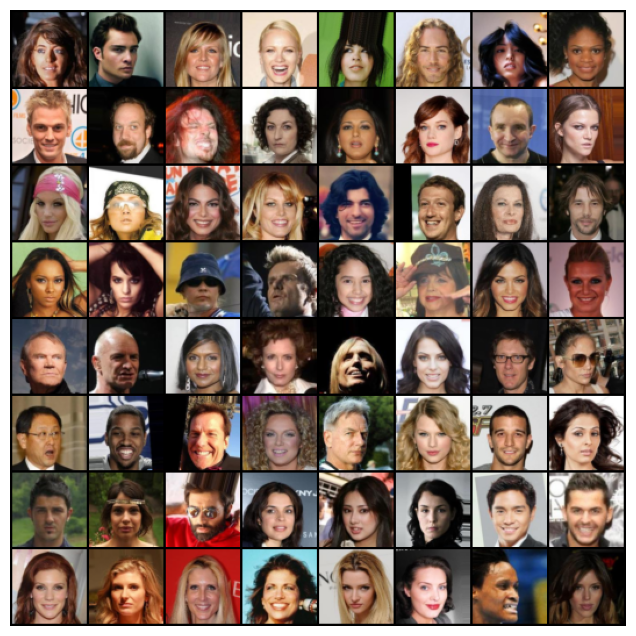

In [16]:

import matplotlib.pyplot as plt
import torchvision

imgs, _ = next(iter(train_loader))
imgs = (imgs * 0.5) + 0.5
grid = torchvision.utils.make_grid(imgs[:64], nrow=8)

plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.show()

# Model

In [5]:
import math
from typing import Tuple, Sequence, Set, Optional
import torch
import torch.nn as nn
import torch.nn.functional as F

class SinusoidalPosEmb(nn.Module):
    """Embedding sinusoidal estándar para timesteps (t) -> R^dim."""
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        half = self.dim // 2
        device = t.device
        emb = math.log(10000) / (half - 1)
        emb = torch.exp(torch.arange(half, device=device) * -emb)
        emb = t.float().unsqueeze(1) * emb.unsqueeze(0)
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0,1))
        return emb


class TimeMLP(nn.Module):
    """Proyecta el embedding sinusoidal a un espacio (time_dim) con activación."""
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.SiLU(),
            nn.Linear(out_dim, out_dim),)

    def forward(self, t_emb: torch.Tensor) -> torch.Tensor:
        return self.net(t_emb)  # (B, out_dim)

def group_norm(channels: int, num_groups: int = 32) -> nn.GroupNorm:
    return nn.GroupNorm(num_groups=min(num_groups, channels), num_channels=channels, eps=1e-6, affine=True)

class ResBlock(nn.Module):
    """
    Residual block con GN + SiLU + Conv, condicionado por el embedding temporal.
    Cada bloque puede cambiar el # de canales (in_ch -> out_ch).
    """
    def __init__(self, in_ch: int, out_ch: int, time_dim: int, dropout: float = 0.0):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch

        self.norm1 = group_norm(in_ch)
        self.act1  = nn.SiLU()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)

        # Proyección del tiempo al sesgo por canal
        self.time_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_dim, out_ch))

        self.norm2 = group_norm(out_ch)
        self.act2  = nn.SiLU()
        self.drop  = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)

        # Skip si cambia número de canales
        self.skip = nn.Identity() if in_ch == out_ch else nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor) -> torch.Tensor:
        h = self.conv1(self.act1(self.norm1(x)))
        # Añadimos conditioning del tiempo como sesgo por canal
        # (B, out_ch) -> (B, out_ch, 1, 1)
        t_bias = self.time_proj(t_emb).unsqueeze(-1).unsqueeze(-1)
        h = h + t_bias
        h = self.conv2(self.drop(self.act2(self.norm2(h))))
        return h + self.skip(x)


class AttnBlock(nn.Module):
    """
    Auto-atención espacial multi-head simple para mapas (B, C, H, W).
    Pre-norm → QKV → atención → proyección.
    Usar en resoluciones bajas (p.ej., 16x16 y 8x8).
    """
    def __init__(self, channels: int, num_heads: int = 4, head_dim: int = 64):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        self.head_dim = head_dim
        inner = num_heads * head_dim

        self.norm = group_norm(channels)
        self.qkv  = nn.Conv2d(channels, inner * 3, kernel_size=1, bias=False) # Proyeccion KQV, Kernel de 1 es una proyeccion
        self.proj = nn.Conv2d(inner, channels, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, h, w = x.shape
        h_in = self.norm(x)

        qkv = self.qkv(h_in)  # (B, 3*inner, H, W)
        q, k, v = torch.chunk(qkv, 3, dim=1)  # Dividimos el tensor proyectado en (B, inner, H, W) cada uno

        # reshapes a (B, heads, head_dim, HW)
        def reshape_heads(t):
            t = t.reshape(b, self.num_heads, self.head_dim, h * w)
            return t

        q = reshape_heads(q)
        k = reshape_heads(k)
        v = reshape_heads(v)

        # atenciones: (B, heads, HW, HW)
        attn = torch.einsum('bhcn,bhdn->bhcd', q, k) / math.sqrt(self.head_dim) # Einstein summation
        attn = attn.softmax(dim=-1)

        out = torch.einsum('bhcd,bhdn->bhcn', attn, v)
        out = out.reshape(b, self.num_heads * self.head_dim, h, w)
        out = self.proj(out)
        return x + out


In [6]:
class Downsample(nn.Module):
    """Downsample por factor 2 con conv (stride=2) para evitar aliasing excesivo."""
    def __init__(self, channels: int):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)

class Upsample(nn.Module):
    """Upsample ×2 por interpolación + conv (evita checkerboard)."""
    def __init__(self, channels: int):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.conv(x)

class UNetDenoiser(nn.Module):
    """
    U-Net para DDPM (predice ε).
    - in_channels: 3 (RGB)
    - base_channels: canales iniciales (p.ej., 128)
    - channel_mults: multiplicadores por nivel (64->32->16->8->...); p.ej., (1,2,2,2) para 64x64
    - num_res_blocks: # de ResBlocks por resolución en encoder/decoder
    - attn_resolutions: resoluciones (H o W) donde aplicar atención (p.ej., {16, 8})
    - time_dim: dimensión del embedding temporal proyectado
    """
    def __init__(self,
        in_channels: int = 3,
        base_channels: int = 128,
        channel_mults: Sequence[int] = (1, 2, 2, 2),
        num_res_blocks: int = 2,
        attn_resolutions: Set[int] = frozenset({16, 8}),
        time_embed_dim: int = 512,
        dropout: float = 0.0,
        num_heads: int = 4,
        head_dim: int = 64,
        img_resolution: int = 64):

        super().__init__()

        # Embedding temporal
        self.time_pos_emb = SinusoidalPosEmb(time_embed_dim)
        self.time_mlp  = TimeMLP(time_embed_dim, time_embed_dim)

        # Conv de entrada/salida
        self.in_conv  = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1)
        self.out_norm = group_norm(base_channels)
        self.out_act  = nn.SiLU()
        self.out_conv = nn.Conv2d(base_channels, in_channels, kernel_size=3, padding=1)

        # Construcción encoder
        ch = base_channels
        self.downs = nn.ModuleList()
        self.skip_shapes = []

        in_ch = ch
        resolutions = [img_resolution]
        for mult in channel_mults:
            out_ch = base_channels * mult
            blocks = nn.ModuleList()
            for _ in range(num_res_blocks):
                blocks.append(ResBlock(in_ch, out_ch, time_dim=time_embed_dim, dropout=dropout)) # Bloques ResNet
                in_ch = out_ch
                # atención opcional en esta resolución
                if resolutions[-1] in attn_resolutions:
                    blocks.append(AttnBlock(in_ch, num_heads=num_heads, head_dim=head_dim)) # Atencion en bajas capas

            # Al final del nivel, si no es último, downsample
            down = nn.Module()
            down.blocks = blocks
            down.down = Downsample(in_ch) if mult != channel_mults[-1] else nn.Identity() # Reducimos resolucion en Encoder
            self.downs.append(down)
            if mult != channel_mults[-1]:
                resolutions.append(resolutions[-1] // 2)

        # Bottleneck
        self.mid = nn.ModuleList([
            ResBlock(in_ch, in_ch, time_dim=time_embed_dim, dropout=dropout),
            AttnBlock(in_ch, num_heads=num_heads, head_dim=head_dim) if (resolutions[-1]//2) in attn_resolutions else nn.Identity(),
            ResBlock(in_ch, in_ch, time_dim=time_embed_dim, dropout=dropout),])

        # Construcción decoder (mirror)
        self.ups = nn.ModuleList()
        for mult in reversed(channel_mults):
            out_ch = base_channels * mult
            blocks = nn.ModuleList()
            for _ in range(num_res_blocks + 1):
                blocks.append(ResBlock(in_ch + out_ch if _ == 0 else in_ch, out_ch, time_dim=time_embed_dim, dropout=dropout))
                in_ch = out_ch
                res_for_attn = resolutions[-1] if mult == channel_mults[0] else (resolutions[-1] * 2)

                if res_for_attn in attn_resolutions:
                    blocks.append(AttnBlock(in_ch, num_heads=num_heads, head_dim=head_dim))

            up = nn.Module()
            up.blocks = blocks
            up.up = Upsample(in_ch) if mult != channel_mults[0] else nn.Identity() # Aumentamos resolucion en Decoder
            self.ups.append(up)

            if mult != channel_mults[0]:
                resolutions.append(resolutions[-1] * 2)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
      """
      x: (B, 3, H, W) en [-1, 1]
      t: (B,) timesteps (int o float)
      retorna: eps_pred (B, 3, H, W)
      """
      # Embedding temporal
      t_emb = self.time_mlp(self.time_pos_emb(t))  # (B, time_dim)

      # Encoder
      h = self.in_conv(x)
      skips = []
      cur = h
      for down in self.downs:
          for blk in down.blocks:
              if isinstance(blk, ResBlock):
                  cur = blk(cur, t_emb)
              else:
                  cur = blk(cur)
          skips.append(cur)
          cur = down.down(cur)

      # Bottleneck
      for blk in self.mid:
          if isinstance(blk, ResBlock):
              cur = blk(cur, t_emb)
          else:
              cur = blk(cur)

      # Decoder
      for up in self.ups:
          # subimos resolución si este nivel lo requiere
          if not isinstance(up.up, torch.nn.Identity):
              cur = up.up(cur)

          skip = skips.pop()
          if cur.shape[-2:] != skip.shape[-2:]:
              cur = torch.nn.functional.interpolate(cur, size=skip.shape[-2:], mode="nearest")

          # concatenamos canales
          cur = torch.cat([cur, skip], dim=1)

          for blk in up.blocks:
              if isinstance(blk, ResBlock):
                  cur = blk(cur, t_emb)
              else:
                  cur = blk(cur)

      # Salida
      out = self.out_conv(self.out_act(self.out_norm(cur)))
      return out  # ε̂: (B, 3, H, W)

def build_unet_64x64(
    in_channels: int = 3,
    base_channels: int = 128,
    channel_mults: Tuple[int, ...] = (1, 2, 2, 2),
    num_res_blocks: int = 2,
    attn_resolutions: Set[int] = frozenset({16, 8}),
    time_embed_dim: int = 512,
    dropout: float = 0.1,
    num_heads: int = 4,
    head_dim: int = 64,):

    return UNetDenoiser(
        in_channels=in_channels,
        base_channels=base_channels,
        channel_mults=channel_mults,
        num_res_blocks=num_res_blocks,
        attn_resolutions=attn_resolutions,
        time_embed_dim=time_embed_dim,
        dropout=dropout,
        num_heads=num_heads,
        head_dim=head_dim,
        img_resolution=64)

In [7]:
from typing import Literal, Tuple, Optional

ScheduleKind = Literal["linear", "cosine"]

def _extract(a: torch.Tensor, t: torch.Tensor, x_shape: torch.Size) -> torch.Tensor:
    """
    Toma un vector 1D (longitud T) y lo indexa por t (B,), devolviendo (B, 1, 1, 1)
    broadcastable al tamaño de x.
    """
    out = a.gather(-1, t.clamp(min=0).long())
    return out.reshape((t.shape[0],) + (1,) * (len(x_shape) - 1))

def _beta_schedule_linear(T: int, beta_min: float = 1e-4, beta_max: float = 2e-2) -> torch.Tensor:
    """
    Schedule lineal clásico: beta_t en [beta_min, beta_max].
    """
    return torch.linspace(beta_min, beta_max, T, dtype=torch.float32)

def _alpha_bar_cosine(t: torch.Tensor, s: float = 0.008) -> torch.Tensor:
    """
    Alphas-bar continuas según Nichol & Dhariwal (cosine schedule):
        alpha_bar(t) = cos^2( ((t/T + s)/(1+s)) * (pi/2) )
    Asume t ∈ [0, 1]. Retorna alpha_bar(t) ∈ (0,1].
    """
    x = (t + s) / (1.0 + s)
    return torch.cos((math.pi / 2.0) * x).clamp(min=1e-7) ** 2


def _beta_schedule_cosine(T: int, s: float = 0.008) -> torch.Tensor:
    """
    Discretiza alpha_bar(t) por diferencias para obtener beta_t.
    """
    steps = torch.arange(T + 1, dtype=torch.float32) / T  # 0..1
    alphas_bar = _alpha_bar_cosine(steps, s=s)
    alphas_bar = alphas_bar / alphas_bar[0]  # normaliza para que alpha_bar(0)=1
    betas = 1 - (alphas_bar[1:] / alphas_bar[:-1])
    return betas.clamp(min=1e-8, max=0.999)

class Diffusion(nn.Module):
    """
    Precomputes y expone tensores necesarios para DDPM:
      - betas, alphas, alphas_cumprod (alpha_bar), y sus raíces/inversas
      - q_sample(x0, t, eps): x_t = sqrt(alpha_bar_t) x0 + sqrt(1-alpha_bar_t) eps
      - predict_x0(x_t, eps_pred, t)
      - posterior_mean_variance(x_t, x0_hat, t) -> mean, var, logvar
      - p_sample_step(...): un paso DDPM (estocástico)
    """
    def __init__(
        self,
        T: int = 1000,
        schedule: ScheduleKind = "linear",
        beta_min: float = 1e-4,
        beta_max: float = 2e-2,
        cosine_s: float = 0.008,
        clamp_x0: bool = True,
        dynamic_threshold: Optional[float] = None , img_size=None):

        super().__init__()
        self.T = int(T)
        self.clamp_x0 = clamp_x0
        self.dynamic_threshold = dynamic_threshold
        self.img_size = img_size

        if schedule == "linear":
            betas = _beta_schedule_linear(T, beta_min, beta_max)
        elif schedule == "cosine":
            betas = _beta_schedule_cosine(T, s=cosine_s)
        else:
            raise ValueError(f"schedule desconocido: {schedule}")

        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        # Buffers para mover a device automáticamente con .to(device)
        self.register_buffer("betas", betas, persistent=False)
        self.register_buffer("alphas", alphas, persistent=False)
        self.register_buffer("alphas_cumprod", alphas_cumprod, persistent=False)
        self.register_buffer("sqrt_alphas_cumprod", torch.sqrt(alphas_cumprod), persistent=False)
        self.register_buffer("sqrt_one_minus_alphas_cumprod", torch.sqrt(1.0 - alphas_cumprod), persistent=False)
        self.register_buffer("alphas_cumprod_prev", F.pad(alphas_cumprod[:-1], (1,0), value=1.0), persistent=False)

        # Posterior q(x_{t-1} | x_t, x_0) varianza y coeficientes
        # \tilde{beta}_t = (1 - \bar{α}_{t-1}) / (1 - \bar{α}_t) * β_t
        posterior_variance = betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        # numerically stable log
        self.register_buffer("posterior_variance", posterior_variance.clamp(min=1e-20), persistent=False)
        self.register_buffer("posterior_log_variance", torch.log(posterior_variance.clamp(min=1e-20)), persistent=False)
        # posterior mean coef: (√ᾱ_{t-1} β_t / (1-ᾱ_t)) x0 + (√α_t (1-ᾱ_{t-1})/(1-ᾱ_t)) x_t
        self.register_buffer(
            "posterior_mean_coef1",
            betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod),
            persistent=False)

        self.register_buffer(
            "posterior_mean_coef2",
            (1.0 - self.alphas_cumprod_prev) * torch.sqrt(alphas) / (1.0 - self.alphas_cumprod),
            persistent=False)

    # --------- q(x_t | x_0) y utilidades ----------

    def sample_timesteps(self, batch_size: int, device=None) -> torch.Tensor:
        """
        Devuelve t ~ Uniform{1..T-1} (evita t=0 para la pérdida, aunque puedes incluirlo).
        """
        if device is None:
            device = self.betas.device
        return torch.randint(1, self.T, (batch_size,), device=device, dtype=torch.long)


    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Muestra x_t ~ q(x_t | x_0) a partir de ruido eps ~ N(0, I):
            x_t = sqrt(alpha_bar_t) * x0 + sqrt(1 - alpha_bar_t) * eps
        """
        if eps is None:
            eps = torch.randn_like(x0)

        sqrt_ab = _extract(self.sqrt_alphas_cumprod, t, x0.shape)
        sqrt_omb = _extract(self.sqrt_one_minus_alphas_cumprod, t, x0.shape)
        return sqrt_ab * x0 + sqrt_omb * eps


    ## Main function for Training ###
    def loss_simple(
        self,
        model_eps_pred_fn,   # callable(x_t, t) -> eps_pred
        x0: torch.Tensor,
        t: torch.Tensor,
        noise: Optional[torch.Tensor] = None,
        weight: Optional[torch.Tensor] = None) -> torch.Tensor:

        """
        L_simple (MSE) entre ε y ε̂:
           E[ || ε - ε̂(x_t, t) ||^2 ]
        Permite pesos opcionales (p.ej., reweighting por t).
        """
        if noise is None:
            noise = torch.randn_like(x0)

        x_t = self.q_sample(x0, t, eps=noise)
        eps_pred = model_eps_pred_fn(x_t, t)
        mse = (noise - eps_pred).pow(2).mean(dim=(1,2,3))
        if weight is not None:
            mse = mse * weight
        return mse.mean()


    ## Inference ###
    def posterior_mean_variance(
        self, x_t: torch.Tensor, x0_hat: torch.Tensor, t: torch.Tensor):
        """
        Devuelve mean, var, logvar de q(x_{t-1} | x_t, x0_hat).
        """
        coef1 = _extract(self.posterior_mean_coef1, t, x_t.shape)
        coef2 = _extract(self.posterior_mean_coef2, t, x_t.shape)
        mean = coef1 * x0_hat + coef2 * x_t
        var = _extract(self.posterior_variance, t, x_t.shape)
        logvar = _extract(self.posterior_log_variance, t, x_t.shape)
        return mean, var, logvar

    @torch.no_grad()
    def predict_x0(self, x_t: torch.Tensor, eps_pred: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Reconstruye x0_hat desde x_t y epsilon_predicho:
            x0_hat = (x_t - sqrt(1-ᾱ_t) * eps_pred) / sqrt(ᾱ_t)
        """
        sqrt_ab = _extract(self.sqrt_alphas_cumprod, t, x_t.shape)
        sqrt_omb = _extract(self.sqrt_one_minus_alphas_cumprod, t, x_t.shape)
        x0_hat = (x_t - sqrt_omb * eps_pred) / (sqrt_ab + 1e-12)

        # Opcional: dynamic thresholding (Nichol & Dhariwal) para recortar outliers
        if self.dynamic_threshold is not None:
            s = self.dynamic_threshold
            amax = x0_hat.detach().abs().flatten(1).max(dim=1).values  # (B,)
            # evitamos dividir por 0
            amax = torch.maximum(amax, torch.tensor(1.0, device=x0_hat.device, dtype=x0_hat.dtype))
            x0_hat = (x0_hat.transpose(0, 1) / amax.clamp(min=s).unsqueeze(-1).unsqueeze(-1)).transpose(0, 1)
            x0_hat = x0_hat.clamp(-1, 1)
        elif self.clamp_x0:
            x0_hat = x0_hat.clamp(-1, 1)
        return x0_hat


    ## Metodo Clave para Inferencia ##
    @torch.no_grad()
    def p_sample_step(
        self,
        model_eps_pred_fn,
        x_t: torch.Tensor,
        t: torch.Tensor,
        eta: float = 1.0,
        use_ema_model: bool = True,
        clip_x0: Optional[bool] = None,
        noise: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Un paso de muestreo DDPM:
           1) eps_pred = model(x_t, t)
           2) x0_hat   = predict_x0(x_t, eps_pred, t)
           3) posterior mean/var -> mu, var
           4) x_{t-1} = mu + sigma_t * z (si t>0); si t=0, devolver mu
        - eta no afecta DDPM clásico (variancia fija). Lo dejamos para compatibilidad con DDIM.
        """
        if clip_x0 is None:
            clip_x0 = self.clamp_x0

        eps_pred = model_eps_pred_fn(x_t, t) # Predecimos el ruido con el modelo entrenado
        x0_hat = self.predict_x0(x_t, eps_pred, t) # Reconstruimos imagen
        if clip_x0:
            x0_hat = x0_hat.clamp(-1, 1)

        mean, var, logvar = self.posterior_mean_variance(x_t, x0_hat, t) # Calculamos momentos posteriores

        nonzero_mask = (t > 0).float().reshape((x_t.shape[0],) + (1,) * (x_t.ndim - 1))
        if noise is None:
            noise = torch.randn_like(x_t)
        return mean + nonzero_mask * torch.exp(0.5 * logvar) * noise

    @torch.no_grad()
    def p_sample_step_ddim(
        self,
        model_eps_pred_fn,           # callable(x_t, t) -> eps_pred
        x_t: torch.Tensor,
        t: torch.Tensor,             # (B,) índice actual
        t_prev: torch.Tensor,        # (B,) índice anterior del schedule (<= t)
        eta: float = 0.0,
        clip_x0: bool | None = None,
        noise: torch.Tensor | None = None):

        """
        Un paso DDIM: t -> t_prev. Si eta=0, trayecto determinista (prob.-flow ODE).
        Fórmula:
          x_{t'} = sqrt(ā_{t'}) x0_hat
                + sqrt(1 - ā_{t'} - sigma^2) * dir
                + sigma * z
          dir = (x_t - sqrt(ā_t) x0_hat) / sqrt(1 - ā_t)
          sigma = eta * sqrt((1 - ā_{t'})/(1 - ā_t)) * sqrt(1 - ā_t/ā_{t'})
        """

        if clip_x0 is None:
            clip_x0 = self.clamp_x0
        if noise is None:
            noise = torch.randn_like(x_t)

        # ᾱ_t y ᾱ_{t'}
        a_t      = _extract(self.alphas_cumprod,       t,      x_t.shape)
        a_t_prev = _extract(self.alphas_cumprod, t_prev,      x_t.shape)

        # ε̂ y x0_hat
        eps_pred = model_eps_pred_fn(x_t, t)
        x0_hat   = self.predict_x0(x_t, eps_pred, t)
        if clip_x0:
            x0_hat = x0_hat.clamp(-1, 1)

        # dirección y sigma
        dir_xt = (x_t - torch.sqrt(a_t) * x0_hat) / torch.sqrt(1.0 - a_t + 1e-12)
        sigma  = eta * torch.sqrt((1.0 - a_t_prev) / (1.0 - a_t + 1e-12)) \
                      * torch.sqrt(1.0 - a_t / (a_t_prev + 1e-12))

        # actualización DDIM
        mean   = torch.sqrt(a_t_prev) * x0_hat
        add    = torch.sqrt(torch.clamp(1.0 - a_t_prev - sigma**2, min=0.0)) * dir_xt
        x_prev = mean + add + sigma * noise
        return x_prev



In [ ]:
def count_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters())

def test_DDPM():
    torch.manual_seed(7)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    amp_enabled = device.type == "cuda"

    # Instancias
    # U-Net: sin atención para MVP
    model = build_unet_64x64(attn_resolutions=set(), dropout=0.0)
    diffusion = Diffusion(T=1000, schedule="linear", beta_min=1e-4, beta_max=2e-2)

    model = model.to(device)
    diffusion = diffusion.to(device)

    print(f"[INFO] Device   : {device}")
    print(f"[INFO] Params   : {count_params(model):,} parámetros")
    print(f"[INFO] T steps  : {diffusion.T}")
    print()

    # Batch sintético
    B, C, H, W = 8, 3, 64, 64
    x0 = torch.empty(B, C, H, W, device=device).uniform_(-1.0, 1.0)
    t  = diffusion.sample_timesteps(B, device=device)

    # Forward shape + no NaNs
    with torch.no_grad():
        eps_pred = model(x0, t)
    assert eps_pred.shape == x0.shape, "La salida del U-Net no coincide con (B,3,64,64)"
    assert torch.isfinite(eps_pred).all(), "NaNs/Inf en la salida del U-Net"
    print("[OK] Forward U-Net: shapes y finitud correctos.")

    # L_simple y backward
    # Optimizer dummy para verificar gradientes (no entrenamos)
    opt = torch.optim.AdamW(model.parameters(), lr=1e-4)
    opt.zero_grad(set_to_none=True)

    if amp_enabled:
        scaler = torch.cuda.amp.GradScaler()
        with torch.cuda.amp.autocast():
            loss = diffusion.loss_simple(model, x0, t)
        assert loss.ndim == 0, "La loss debe ser un escalar"
        scaler.scale(loss).backward()
        # Chequeo de gradientes no-nulos (de forma laxa)
        total_grad = 0.0
        for p in model.parameters():
            if p.grad is not None:
                total_grad += float(p.grad.detach().abs().mean().item())
        assert math.isfinite(total_grad) and total_grad > 0.0, "Gradientes no finitos o ~0"
        scaler.step(opt); scaler.update()
    else:
        loss = diffusion.loss_simple(model, x0, t)
        assert loss.ndim == 0, "La loss debe ser un escalar"
        loss.backward()
        total_grad = 0.0
        for p in model.parameters():
            if p.grad is not None:
                total_grad += float(p.grad.detach().abs().mean().item())
        assert math.isfinite(total_grad) and total_grad > 0.0, "Gradientes no finitos o ~0"
        opt.step()

    print(f"[OK] Loss y backward: loss={float(loss):.5f}, grad|mean|≈{total_grad:.3e}")

    # q_sample estadísticas
    with torch.no_grad():
        # Elegimos un t medio-alto (ruido fuerte) y otro chico (ruido suave)
        t_hi = torch.full((B,), int(0.8 * diffusion.T), device=device, dtype=torch.long)
        t_lo = torch.full((B,), int(0.1 * diffusion.T), device=device, dtype=torch.long)

        x_hi = diffusion.q_sample(x0, t_hi)  # debería parecerse a N(0,1) (aprox) tras normalización
        x_lo = diffusion.q_sample(x0, t_lo)  # más cercano a x0

        def stats(z):
            return z.mean().item(), z.std().item(), z.min().item(), z.max().item()

        m_hi, s_hi, mn_hi, mx_hi = stats(x_hi)
        m_lo, s_lo, mn_lo, mx_lo = stats(x_lo)

        assert torch.isfinite(x_hi).all() and torch.isfinite(x_lo).all(), "NaNs/Inf en q_sample"
        print(f"[OK] q_sample stats:")
        print(f" t≈0.8T -> mean={m_hi:+.3f}, std={s_hi:.3f}, min={mn_hi:+.3f}, max={mx_hi:+.3f}")
        print(f" t≈0.1T -> mean={m_lo:+.3f}, std={s_lo:.3f}, min={mn_lo:+.3f}, max={mx_lo:+.3f}")

    # p_sample_step (DDPM 1 paso)
    with torch.no_grad():
        # simulamos un x_t cualquiera para un t específico
        t_step = torch.full((B,), int(0.6 * diffusion.T), device=device, dtype=torch.long)
        x_t = diffusion.q_sample(x0, t_step)

        def model_eps_pred_fn(x, t):
            return model(x, t)  # wrapper explícito (por si luego usamos EMA o CFG)

        x_prev = diffusion.p_sample_step(model_eps_pred_fn, x_t, t_step)
        assert x_prev.shape == x_t.shape and torch.isfinite(x_prev).all(), "p_sample_step falla en shape/NaN"
        print("[OK] p_sample_step: un paso de muestreo DDPM estable.")

    model_attn = build_unet_64x64(attn_resolutions={16, 8}, dropout=0.0).to(device)

    with torch.no_grad():
        y = model_attn(x0, t)
    assert y.shape == x0.shape and torch.isfinite(y).all(), "U-Net+attn: shape/NaN"
    print("[OK] U-Net con atención en 16x16/8x8: shapes correctos.")

    print("\n[ALL GOOD] Sanity checks superados.")

test_DDPM()

---

# Training

---

## EMA class


In [8]:
class EMA:
    """Exponential Moving Average para parámetros del modelo."""
    def __init__(self, model, decay=0.999, device=None):
        self.decay = decay
        self.shadow = []
        self.device = device
        for p in model.parameters():
            if p.requires_grad:
                self.shadow.append(p.detach().clone())
            else:
                self.shadow.append(None)

    @torch.no_grad()
    def update(self, model):
        i = 0
        for p in model.parameters():
            if p.requires_grad:
                if self.device is not None:
                    self.shadow[i] = self.shadow[i].to(self.device)
                self.shadow[i].mul_(self.decay).add_(p.detach(), alpha=1.0 - self.decay)
            i += 1

    @torch.no_grad()
    def copy_to(self, model):
        i = 0
        for p in model.parameters():
            if p.requires_grad:
                p.data.copy_(self.shadow[i].data)
            i += 1

    @torch.no_grad()
    def state_dict(self):
        return {"decay": self.decay, "shadow": self.shadow}

    @torch.no_grad()
    def load_state_dict(self, state):
        self.decay = state["decay"]
        self.shadow = state["shadow"]


---

#

## GradScaler para Train

In [9]:
import inspect
from contextlib import contextmanager, nullcontext

def make_grad_scaler(device: str = "cuda", enabled: bool = True):
    """
    Devuelve un GradScaler compatible con tu versión de PyTorch.
    - Si AMP no está habilitado, devuelve None.
    - Soporta torch.amp.GradScaler('cuda'|'cpu') (algunas versiones)
      y torch.cuda.amp.GradScaler() (otras versiones).
    """
    if not enabled:
        return None

    if hasattr(torch, "amp") and hasattr(torch.amp, "GradScaler"):
        try:
            sig = inspect.signature(torch.amp.GradScaler)
            if len(sig.parameters) >= 1:
                return torch.amp.GradScaler(device if device in ("cuda", "cpu") else "cuda")
            else:
                return torch.amp.GradScaler()
        except Exception:
            pass

    if hasattr(torch.cuda, "amp") and hasattr(torch.cuda.amp, "GradScaler"):
        return torch.cuda.amp.GradScaler()

    return None


@contextmanager
def autocast_ctx(device: str = "cuda", enabled: bool = True):
    """
    Contexto autocast compatible:
      - Usa torch.amp.autocast(device_type='cuda'/'cpu') si existe.
      - Si no, usa torch.cuda.amp.autocast() cuando device='cuda'.
      - Si AMP off, nullcontext().
    """
    if not enabled:
        with nullcontext():
            yield
        return

    if hasattr(torch, "amp") and hasattr(torch.amp, "autocast"):
        with torch.amp.autocast(device_type=("cuda" if device == "cuda" else "cpu")):
            yield
        return

    if device == "cuda" and hasattr(torch.cuda, "amp") and hasattr(torch.cuda.amp, "autocast"):
        with torch.cuda.amp.autocast():
            yield
        return

    with nullcontext():
        yield

---

## Save the model

In [10]:
def save_ckpt(path, model, optimizer, scaler, ema, step: int, extra: dict = None):
    state = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scaler": scaler.state_dict(),
        "ema": ema.state_dict(),
        "step": step}
    if extra:
        state["extra"] = extra
    torch.save(state, path)

def load_ckpt(path, model, optimizer=None, scaler=None, ema=None, map_location="cuda"):
    state = torch.load(path, map_location=map_location)
    model.load_state_dict(state["model"])
    if optimizer is not None and "optimizer" in state:
        optimizer.load_state_dict(state["optimizer"])
    if scaler is not None and "scaler" in state:
        scaler.load_state_dict(state["scaler"])
    if ema is not None and "ema" in state:
        ema.load_state_dict(state["ema"])
    return state.get("step", 0), state.get("extra", {})

---

# Train One Epoch

In [11]:
from torchvision.utils import make_grid, save_image

## Inferencia desde T hasta 0 haciendo denoising ##
@torch.no_grad()
def sample_ddpm(
    model, diffusion, n: int, img_size: int = 64, device="cuda",
    steps: int = None,
    save_path: str = None, return_grid: bool = True):

    model.eval()
    T = diffusion.T if steps is None else steps
    x = torch.randn(n, 3, img_size, img_size, device=device) # Vector aleatorio

    for i in reversed(range(T)):
        t = torch.full((n,), i, device=device, dtype=torch.long)

        def model_eps(x_t, t_t):
            return model(x_t, t_t)
        x = diffusion.p_sample_step(model_eps, x, t) # Quitamos un paso de noise

    x = x.clamp(-1, 1)
    x = (x + 1) * 0.5  # [0,1]
    grid = make_grid(x, nrow=int(n**0.5), padding=2)
    if save_path is not None:
        save_image(grid, save_path)

    return grid if return_grid else x


def get_lr(optimizer):
    return optimizer.param_groups[0]["lr"]

def lr_warmup(optimizer, base_lr, step, warmup_steps=1000):
    """Warmup lineal por pasos (globales)."""
    if warmup_steps is None or warmup_steps <= 0:
        return
    lr = base_lr * min(1.0, (step + 1) / warmup_steps)
    for g in optimizer.param_groups:
        g["lr"] = lr

@torch.no_grad()
def _swap_to_ema_and_sample(
    model, ema, diffusion, sample_fn, sample_n, img_size, device, out_path):

    """Copia EMA → modelo, hace muestras y restaura pesos online."""
    backup = {k: v.detach().clone() for k, v in model.state_dict().items()}
    ema.copy_to(model)
    _ = sample_fn(model, diffusion, n=sample_n, img_size=img_size,
                  device=device, save_path=out_path)
    model.load_state_dict(backup)


def compute_grad_norm(model) -> float:
    total = 0.0
    for p in model.parameters():
        if p.grad is not None:
            total += float(p.grad.detach().pow(2).sum().item())
    return total ** 0.5

def gpu_mem_mb(device="cuda"):
    if torch.cuda.is_available() and device == "cuda":
        alloc = torch.cuda.memory_allocated() / (1024**2)
        reserv = torch.cuda.memory_reserved() / (1024**2)
        return alloc, reserv
    return 0.0, 0.0


def train_one_epoch(
    model,
    diffusion,
    dataloader,
    optimizer,
    *,
    scaler=None,
    ema=None,
    device: str = "cuda",
    max_batches: int | None = None,
    grad_clip: float | None = 1.0,
    use_autocast: bool = True,
    grad_accum_steps: int = 1,
    use_channels_last: bool = False,
    on_oom: str = "skip",
    # warmup por paso
    base_lr: float | None = None,
    warmup_steps: int | None = None,
    global_step: int = 0,
    # DIAGNÓSTICOS
    log_every: int = 0,                       # imprime cada N steps (0 = off)
    probe_timesteps: list[int] | None = None, # e.g., [50, 200, 500, 800]
    log_mem: bool = False,                    # imprime memoria GPU
    log_grad_norm: bool = False,              # imprime ||g||
):
    model.train()
    if use_channels_last:
        model.to(memory_format=torch.channels_last)

    grad_accum_steps = max(1, int(grad_accum_steps))
    optimizer.zero_grad(set_to_none=True)

    total_loss, n_seen_batches, n_seen_images = 0.0, 0, 0

    # encabezado de sección "In-epoch" y baseline
    did_print_in_epoch_header = False
    if log_every and global_step == 0:
        with torch.no_grad():
            xb = torch.randn(32, 3, diffusion.img_size, diffusion.img_size, device=device)
            base = float((xb**2).mean().item())
        print("┆ In-epoch statistics")
        print("┆   (baseline)  ε-MSE ≈ {:.3f}  (esperado ~1.0)".format(base))
        print("┆   {:>8} | {:>9} | {:>8} | {:>8} | {:>10}{}".format(
            "step", "lr", "loss", "dt(ms)", "grad_norm",
            (" | probes[t]" if probe_timesteps else "")
        ))
        print("┆   " + "─"*72)
        did_print_in_epoch_header = True

    ### Begin Training ###
    for i, (x, _) in enumerate(dataloader):
        if (max_batches is not None) and (i >= max_batches):
            break
        try:
            t_start = time.perf_counter()

            x = x.to(device, non_blocking=True)
            if use_channels_last:
                x = x.to(memory_format=torch.channels_last)

            B = x.size(0)
            t = diffusion.sample_timesteps(B, device=device)

            with autocast_ctx(device=device, enabled=bool(use_autocast)):
                loss = diffusion.loss_simple(model, x, t) / grad_accum_steps

            if use_autocast and (scaler is not None):
                scaler.scale(loss).backward()
            else:
                loss.backward()

            step_now = ((i + 1) % grad_accum_steps) == 0
            gnorm = None
            if step_now:
                # Warmup por paso
                if (base_lr is not None) and (warmup_steps is not None) and (warmup_steps > 0):
                    lr = base_lr * min(1.0, (global_step + 1) / warmup_steps)
                    for g in optimizer.param_groups:
                        g["lr"] = lr

                did_unscale = False

                # Grad norm (antes de clip) si se pide
                if log_grad_norm:
                    if use_autocast and (scaler is not None) and (not did_unscale):
                        scaler.unscale_(optimizer)
                        did_unscale = True
                    gnorm = compute_grad_norm(model)

                # Clip + step
                if grad_clip is not None:
                    if use_autocast and (scaler is not None) and (not did_unscale):
                        scaler.unscale_(optimizer)
                        did_unscale = True
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

                if use_autocast and (scaler is not None):
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    optimizer.step()
                optimizer.zero_grad(set_to_none=True)

                if ema is not None:
                    ema.update(model)

                global_step += 1

            total_loss += float(loss.detach()) * grad_accum_steps
            n_seen_batches += 1
            n_seen_images  += B

            # logs compactos por step ─
            if log_every and (global_step % log_every == 0) and step_now:
                if not did_print_in_epoch_header:
                    print("┆ In-epoch statistics")
                    print("┆   {:>8} | {:>9} | {:>8} | {:>8} | {:>10}{}".format(
                        "step", "lr", "loss", "dt(ms)", "grad_norm",
                        (" | probes[t]" if probe_timesteps else "")
                    ))
                    print("┆   " + "─"*72)
                    did_print_in_epoch_header = True

                probe_msg = ""
                if probe_timesteps:
                    with torch.no_grad(), autocast_ctx(device=device, enabled=False):
                        vals = []
                        for tau in probe_timesteps:
                            t_fix = torch.full((B,), int(tau), device=device, dtype=torch.long)
                            v = diffusion.loss_simple(model, x, t_fix).item()
                            vals.append(f"t={tau}:{v:.3f}")
                        probe_msg = " | " + " ".join(vals)

                # (opcional) memoria, pero sin romper el layout
                mem_msg = ""
                if log_mem:
                    alloc, reserv = gpu_mem_mb(device)
                    mem_msg = f" | mem={alloc:.0f}/{reserv:.0f}MB"

                lr_now = optimizer.param_groups[0]["lr"]
                dt = (time.perf_counter() - t_start) * 1000.0
                gn_str = (f"{gnorm:.2e}" if (gnorm is not None) else "—")
                loss_val = (loss.detach() * grad_accum_steps).item()

                print("┆   {:8d} | {:9.2e} | {:8.4f} | {:8.1f} | {:>10}{}{}".format(global_step, lr_now, loss_val, dt, gn_str, mem_msg, probe_msg))

        except RuntimeError as e:
            if ("CUDA out of memory" in str(e)) and (on_oom == "skip"):
                import gc
                gc.collect(); torch.cuda.empty_cache()
                print(f"[WARN][OOM] Batch {i} omitido. Limpié cache y sigo…")
                optimizer.zero_grad(set_to_none=True)
                continue
            else:
                raise

    avg_loss = total_loss / max(1, n_seen_batches)
    return avg_loss, n_seen_batches, n_seen_images, global_step


# Main Train DDPM Model Loop

In [30]:
import os, time

def _fmt_hms(sec: float) -> str:
    m, s = divmod(int(sec), 60)
    h, m = divmod(m, 60)
    return f"{h:d}:{m:02d}:{s:02d}"

def _rule(w=92, ch="─"):  # línea separadora
    return ch * w


def train_ddpm(
    model, diffusion, train_loader, optimizer,
    ema, device="cuda",
    epochs=50, base_lr=2e-4, warmup_steps=1000,
    grad_clip=1.0, use_autocast=True, scaler=None,
    sample_every=5, sample_n=36, img_size=64,
    sample_fn=None,
    ckpt_dir="checkpoints", run_name="ddpm",
    save_every=5, save_last=True,
    resume_path=None, ckpt_utils=None,
    grad_accum_steps: int = 1,
    use_channels_last: bool = False,
    on_oom: str = "skip",
    # DIAG:
    log_every: int = 0,
    probe_timesteps: list[int] | None = None,
    log_mem: bool = False,
    log_grad_norm: bool = False,
    # Sampling diag:
    sample_seed: int | None = 1234,
    sample_steps: int | None = None,
    # control fino al reanudar
    reset_optimizer_state: bool = False,        # no cargar estado del optimizer
    override_lr: float | None = None,           # reasigna LR tras cargar
    override_weight_decay: float | None = None, # reasigna WD tras cargar
    override_ema_decay: float | None = None,    # reasigna EMA.decay tras cargar
):
    import os, time, math
    import torch
    import torchvision.utils as vutils

    os.makedirs(ckpt_dir, exist_ok=True)

    save_ckpt, load_ckpt = (None, None)
    if ckpt_utils is not None:
        save_ckpt, load_ckpt = ckpt_utils

    if scaler is None and use_autocast:
        scaler = make_grad_scaler(device=device, enabled=True)

    # Resumen
    global_step, start_epoch = 0, 0
    resumed = False
    if resume_path and load_ckpt is not None and os.path.exists(resume_path):
        # si queremos resetear el optimizer, no lo pasamos al loader
        opt_for_load = None if reset_optimizer_state else optimizer
        step_loaded, extra = load_ckpt(
            resume_path, model,
            optimizer=opt_for_load,
            scaler=scaler, ema=ema,
            map_location=device)

        if isinstance(extra, dict):
            global_step = int(extra.get("global_step", step_loaded or 0))
            start_epoch = int(extra.get("epoch", 0)) + 1
        print(f"[RESUME] Cargado: {resume_path} | global_step={global_step} | start_epoch={start_epoch}")

        # Overrides SOLO si reanudamos
        if reset_optimizer_state:
            print("[RESUME] Optimizer: estado NO cargado (reset).")
        if override_lr is not None:
            for g in optimizer.param_groups:
                g["lr"] = float(override_lr)
            print(f"[RESUME] override_lr → {override_lr:.3e}")
        if override_weight_decay is not None:
            for g in optimizer.param_groups:
                g["weight_decay"] = float(override_weight_decay)
            print(f"[RESUME] override_weight_decay → {override_weight_decay:.3e}")
        if override_ema_decay is not None:
            # algunas clases EMA guardan decay en state; aquí lo forzamos
            if hasattr(ema, "decay"):
                ema.decay = float(override_ema_decay)
            print(f"[RESUME] override_ema_decay → {override_ema_decay:.6f}")
        resumed = True

    #  Header
    ema_decay = getattr(ema, "decay", None)
    ema_str   = f"{ema_decay:.6f}" if isinstance(ema_decay, (float, int)) else "on"
    print(_rule())
    print(f"DDPM run: {run_name}")
    print(f"Device: {device} | autocast: {use_autocast} | EMA: {ema_str} | "
          f"epochs: {epochs} | base_lr: {base_lr:.2e} | warmup_steps: {warmup_steps}")
    if resumed:
        print("Overrides activos al reanudar:",
              f"reset_opt={reset_optimizer_state}",
              f"override_lr={override_lr}",
              f"override_wd={override_weight_decay}",
              f"override_ema={override_ema_decay}", sep=" ")
    print(_rule())
    print(f"{'ep':>3} | {'step':>8} | {'loss':>10} | {'lr':>9} | "
          f"{'batches':>8} | {'images':>8} | {'imgs/s':>7} | {'time':>8} | {'warmup':>6}")
    print(_rule())

    total_time = 0.0

    for epoch in range(start_epoch, epochs):
        t0 = time.time()

        avg_loss, n_batches, n_images, global_step = train_one_epoch(
            model=model, diffusion=diffusion, dataloader=train_loader, optimizer=optimizer,
            scaler=scaler, ema=ema, device=device,
            grad_clip=grad_clip, use_autocast=use_autocast,
            grad_accum_steps=grad_accum_steps, use_channels_last=use_channels_last, on_oom=on_oom,
            base_lr=base_lr, warmup_steps=warmup_steps, global_step=global_step,
            log_every=log_every, probe_timesteps=probe_timesteps,
            log_mem=log_mem, log_grad_norm=log_grad_norm)

        sec = time.time() - t0
        total_time += sec
        ips = (n_images / sec) if sec > 0 else 0.0
        lr_now = optimizer.param_groups[0]["lr"]
        warm_prog = 0.0 if not warmup_steps else min(1.0, global_step / float(warmup_steps))

        print(f"{epoch:3d} | {global_step:8d} | {avg_loss:10.5f} | {lr_now:9.2e} | "
              f"{n_batches:8d} | {n_images:8d} | {ips:7.1f} | {_fmt_hms(sec):>8} | {int(100*warm_prog):3d}%")

        # Muestras (EMA swap temporal)
        if (sample_fn is not None) and ((epoch % sample_every == 0) or (epoch == epochs - 1)):
            out_path = os.path.join(ckpt_dir, f"{run_name}_samples_e{epoch:03d}.png")
            backup = {k: v.detach().clone() for k, v in model.state_dict().items()}
            ema.copy_to(model)
            if sample_seed is not None:
                torch.manual_seed(sample_seed)
            _ = sample_fn(model, diffusion, n=sample_n, img_size=img_size,
                          device=device, save_path=out_path)
            model.load_state_dict(backup)
            print(f"└─ [SAMPLE] grid → {out_path}")

        # Checkpoints
        if (save_ckpt is not None) and ((epoch % save_every == 0) or (epoch == epochs - 1)):
            ckpt_path = os.path.join(ckpt_dir, f"{run_name}_e{epoch:03d}.pt")
            save_ckpt(ckpt_path, model, optimizer, scaler, ema,
                      step=global_step, extra={"epoch": epoch, "global_step": global_step})
            print(f"└─ [CKPT]   saved → {ckpt_path}")

    if save_last and (save_ckpt is not None):
        ckpt_path = os.path.join(ckpt_dir, f"{run_name}_last.pt")
        save_ckpt(ckpt_path, model, optimizer, scaler, ema,
                  step=global_step, extra={"epoch": epochs-1, "global_step": global_step})
        print(f"└─ [CKPT]   saved → {ckpt_path}")

    print(_rule())
    print(f"Entrenamiento finalizado en {_fmt_hms(total_time)}")
    print(_rule())


In [22]:
import gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.empty_cache()

In [25]:
from torch.optim import AdamW

device = "cuda" if torch.cuda.is_available() else "cpu"

#model_base = build_unet_64x64(attn_resolutions=set(), dropout=0.1).to(device)

#model_low_gpu = build_unet_64x64(base_channels=96, channel_mults=(1, 2, 2, 2), num_res_blocks=1, attn_resolutions={8},  num_heads=2, head_dim=32, dropout=0.1).to(device)

model_attention = build_unet_64x64(base_channels=128, attn_resolutions={16, 8}, dropout=0.1, num_heads=4,head_dim=64).to(device)

diffusion = Diffusion(T=1000, schedule="linear", beta_min=1e-4, beta_max=2e-2 , img_size=64 , dynamic_threshold=0.95).to(device)
ema = EMA(model_attention, decay=0.9997, device=device)

optimizer = AdamW(model_attention.parameters(), lr=2e-4, betas=(0.9, 0.999), weight_decay=0.005)
scaler = None


In [24]:
del model_attention
del diffusion
del ema

In [26]:
torch.backends.cudnn.benchmark = True

train_ddpm(
    model=model_attention, diffusion=diffusion, train_loader=train_loader, optimizer=optimizer,
    ema=ema, device=device,
    epochs=20, base_lr=2e-4, warmup_steps=2300,
    grad_clip=1.0, use_autocast=True, scaler=None,   # que el wrapper cree el scaler
    sample_every=3, sample_n=16, img_size=64,
    sample_fn=sample_ddpm,
    ckpt_dir="checkpoints", run_name="celeba64_ddpm_attn",
    save_every=8, save_last=True, resume_path=None, ckpt_utils=(save_ckpt, load_ckpt),
    grad_accum_steps=1, use_channels_last=True, on_oom="skip",

    # DIAG:
    log_every=200,                  # imprime cada 200 steps efectivos
    probe_timesteps=[10, 50, 200, 500],
    log_mem=True,                   # memoria GPU asignada/reservada
    log_grad_norm=True,             # ||grad||
    sample_seed=1234,               # grids comparables entre épocas
    sample_steps=None               # (para DDIM/fast-sampling más adelante)
)


────────────────────────────────────────────────────────────────────────────────────────────
DDPM run: celeba64_ddpm_attn
Device: cuda | autocast: True | EMA: 0.999700 | epochs: 20 | base_lr: 2.00e-04 | warmup_steps: 2300
────────────────────────────────────────────────────────────────────────────────────────────
 ep |     step |       loss |        lr |  batches |   images |  imgs/s |     time | warmup
────────────────────────────────────────────────────────────────────────────────────────────
┆ In-epoch statistics
┆   (baseline)  ε-MSE ≈ 0.997  (esperado ~1.0)
┆       step |        lr |     loss |   dt(ms) |  grad_norm | probes[t]
┆   ────────────────────────────────────────────────────────────────────────
┆        400 |  3.48e-05 |   0.0502 |  10884.1 |   3.67e-01 | mem=468/5118MB | t=10:0.530 t=50:0.201 t=200:0.068 t=500:0.031
  0 |      782 |    0.16590 |  6.80e-05 |      782 |   100000 |   246.5 |  0:06:45 |  34%
└─ [SAMPLE] grid → checkpoints/celeba64_ddpm_attn_samples_e000.png


In [ ]:
resume_path = "/content/checkpoints/celeba64_ddpm_attn_last.pt"
ema = EMA(model_attention, decay=0.9997, device=device)
optimizer = AdamW(model_attention.parameters(), lr=2e-4, betas=(0.9, 0.999), weight_decay=0.01)

train_ddpm(
    model=model_attention, diffusion=diffusion, train_loader=train_loader, optimizer=optimizer,
    ema=ema, device=device,
    epochs=35, base_lr=2e-4, warmup_steps=0,
    grad_clip=1.0, use_autocast=True, scaler=None,
    sample_every=2, sample_n=16, img_size=64,
    sample_fn=sample_ddpm,
    ckpt_dir="checkpoints", run_name="celeba64_ddpm_attn",
    save_every=8, save_last=True, resume_path=resume_path, ckpt_utils=(save_ckpt, load_ckpt),
    grad_accum_steps=1, use_channels_last=True, on_oom="skip",
    # DIAG
    log_every=200, probe_timesteps=[10, 50, 200, 500],
    log_mem=True, log_grad_norm=True,
    sample_seed=1234, sample_steps=None,
    reset_optimizer_state=False,          # cargar momentos AdamW
    override_lr=2e-4,                     # re-asigna
    override_weight_decay=0.005,          # re-asigna
    override_ema_decay=0.9998,            # re-asigna
)



[RESUME] Cargado: /content/checkpoints/celeba64_ddpm_attn_last.pt | global_step=15640 | start_epoch=20
[RESUME] override_lr → 2.000e-04
[RESUME] override_weight_decay → 5.000e-03
[RESUME] override_ema_decay → 0.999800
────────────────────────────────────────────────────────────────────────────────────────────
DDPM run: celeba64_ddpm_attn
Device: cuda | autocast: True | EMA: 0.999800 | epochs: 35 | base_lr: 2.00e-04 | warmup_steps: 0
Overrides activos al reanudar: reset_opt=False override_lr=0.0002 override_wd=0.005 override_ema=0.9998
────────────────────────────────────────────────────────────────────────────────────────────
 ep |     step |       loss |        lr |  batches |   images |  imgs/s |     time | warmup
────────────────────────────────────────────────────────────────────────────────────────────
┆ In-epoch statistics
┆       step |        lr |     loss |   dt(ms) |  grad_norm | probes[t]
┆   ────────────────────────────────────────────────────────────────────────
┆      158

# Testing

---

In [ ]:
import torchvision.utils as vutils

@torch.no_grad()
def ddpm_infer_sample(
    model,
    diffusion,
    n: int = 36,
    img_size: int = 64,
    device: str = "cuda",*,
    ema=None,
    out_path: str = "samples_ddpm.png",
    save_individual: bool = False,
    out_dir: str = "samples_individual",
    seed: int | None = 1234):

    """
    Genera n imágenes con DDPM ancestral (T pasos) y guarda un grid.
    Requiere: diffusion.p_sample_step(model_eps, x_t, t)
    """
    model_was_training = model.training
    model.eval()

    backup_state = None
    if ema is not None:
        backup_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
        ema.copy_to(model)

    if seed is not None:
        torch.manual_seed(seed)

    B = n
    x = torch.randn(B, 3, img_size, img_size, device=device)

    for i in reversed(range(diffusion.T)):
        t = torch.full((B,), i, device=device, dtype=torch.long)
        x = diffusion.p_sample_step(lambda x_t, t_t: model(x_t, t_t), x, t)

    x = (x.clamp(-1, 1) + 1) * 0.5

    nrow = int(math.sqrt(B))
    grid = vutils.make_grid(x, nrow=nrow, padding=2)
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    vutils.save_image(grid, out_path)
    print(f"[INFER] Grid guardado en: {out_path}")

    if save_individual:
        os.makedirs(out_dir, exist_ok=True)
        for idx in range(B):
            vutils.save_image(x[idx], os.path.join(out_dir, f"img_{idx:03d}.png"))
        print(f"[INFER] {B} imágenes individuales guardadas en: {out_dir}")

    if backup_state is not None:
        model.load_state_dict(backup_state)
    model.train(model_was_training)

    return grid

_ = ddpm_infer_sample(
    model=model_low_gpu,
    diffusion=diffusion,
    n=36,
    img_size=64,
    device=device,
    ema=ema,
    out_path="checkpoints/celeba64_samples_e2.png",
    save_individual=False,
    out_dir="checkpoints/celeba64_samples_e0_indiv" , seed=7)

[INFER] Grid guardado en: checkpoints/celeba64_samples_e2.png


In [ ]:
diffusion = Diffusion(T=1000, schedule="linear", beta_min=1e-4, beta_max=2e-2 , img_size=64).to(device)

@torch.no_grad()
def ddim_infer_sample(
    model,
    diffusion,
    n: int = 36,
    img_size: int = 64,
    device: str = "cuda",
    *,
    ema=None,
    out_path: str = "samples_ddim.png",
    save_individual: bool = False,
    out_dir: str = "samples_individual",
    seed: Optional[int] = 1234,
    # DDIM params
    steps: int = 50,                 # nº de pasos de muestreo (<< T)
    eta: float = 0.0,                # 0 = determinista, >0 añade ruido
    schedule_kind: str = "linear",   # "linear" o "cosine" para espaciar los t
    schedule_idx = None,          # lista explícita de t (descendentes)
):
    """
    Genera n imágenes con DDIM (steps << T) y guarda un grid.
    Requiere: diffusion.p_sample_step_ddim(model_eps, x_t, t, t_prev, eta).
    """
    # --- modo eval + (opcional) swap a EMA ---
    was_training = model.training
    model.eval()
    backup_state = None
    if ema is not None:
        backup_state = {k: v.detach().clone() for k, v in model.state_dict().items()}
        ema.copy_to(model)

    if seed is not None:
        torch.manual_seed(seed)

    B = n
    x = torch.randn(B, 3, img_size, img_size, device=device)

    #  construir schedule de índices (t) descendente: T-1 -> ... -> 0
    T = diffusion.T
    if schedule_idx is None:
        if schedule_kind == "cosine":
            s = torch.linspace(0, 1, steps, device=device)
            w = 0.5 * (1 - torch.cos(math.pi * s))
            idx = torch.round((T - 1) * (1 - w)).long()
        else:
            idx = torch.round(torch.linspace(T - 1, 0, steps, device=device)).long()
        schedule = sorted(set(idx.tolist()), reverse=True)
    else:
        schedule = sorted(set(int(t) for t in schedule_idx), reverse=True)

    # loop DDIM: t -> t_prev
    for i, t_cur in enumerate(schedule):
        t_cur_t = torch.full((B,), t_cur, device=device, dtype=torch.long)
        t_prev  = schedule[i + 1] if i + 1 < len(schedule) else 0
        t_prev_t = torch.full((B,), t_prev, device=device, dtype=torch.long)

        x = diffusion.p_sample_step_ddim(
            lambda x_t, tt: model(x_t, tt),
            x_t=x,
            t=t_cur_t,
            t_prev=t_prev_t,
            eta=eta,
            clip_x0=True,
            noise=None,  # DDIM puede ser determinista si eta=0
        )

    x_vis = (x.clamp(-1, 1) + 1) * 0.5
    nrow = int(math.sqrt(B)) if int(math.sqrt(B))**2 == B else math.ceil(math.sqrt(B))
    grid = vutils.make_grid(x_vis, nrow=nrow, padding=2)
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    vutils.save_image(grid, out_path)
    print(f"[INFER-DDIM] Grid guardado en: {out_path}  (steps={len(schedule)}, eta={eta})")

    if save_individual:
        os.makedirs(out_dir, exist_ok=True)
        for i in range(B):
            vutils.save_image(x_vis[i], os.path.join(out_dir, f"img_{i:03d}.png"))
        print(f"[INFER-DDIM] {B} imágenes individuales guardadas en: {out_dir}")

    if backup_state is not None:
        model.load_state_dict(backup_state)
    model.train(was_training)

    return grid

_ = ddim_infer_sample(
    model_low_gpu, diffusion,
    n=36, img_size=64, device=device,
    ema=ema,
    out_path="checkpoints/celeba64_ddim150.png",
    seed=7,
    steps=150, eta=0.0,             # 150 pasos, determinista
    schedule_kind="linear",
    save_individual=False
)

[INFER-DDIM] Grid guardado en: checkpoints/celeba64_ddim150.png  (steps=150, eta=0.0)


---

In [ ]:

@torch.no_grad()
def render_denoise_strip(
    model,
    diffusion,
    *,
    img_size: int = 64,
    device: str = "cuda",
    ema=None,                   # opcional: usar EMA para muestrear
    seed: int | None = 1234,
    out_path: str = "denoise_strip.png",
    capture_steps: list[int] | None = None,   # índices t del reverse a capturar
    pad: int = 2                               # padding entre celdas del grid
):
    """
    Genera una única muestra x_T~N(0,I) y la denoisa T→0.
    Captura snapshots en 'capture_steps' y guarda un grid 1×K (una fila).

    - 'capture_steps' son índices de t (0..T-1) del reverse; si None, toma ~20 equiespaciados.
    - Devuelve el tensor (C,H,W) del grid (normalizado en [0,1]).
    """
    was_training = model.training
    model.eval()

    # swap temporal a EMA si se provee
    backup = None
    if ema is not None:
        backup = {k: v.detach().clone() for k, v in model.state_dict().items()}
        ema.copy_to(model)

    if seed is not None:
        torch.manual_seed(seed)

    T = diffusion.T
    if capture_steps is None:
        K = 20
        capture_steps = [int(x) for x in torch.linspace(T-1, 0, K).round().tolist()]
    # orden descendente para el loop reverse y luego invertimos para visualizar izq→der
    capture_set = set(capture_steps)

    x = torch.randn(1, 3, img_size, img_size, device=device)
    frames = []

    for t_int in range(T-1, -1, -1):
        t = torch.full((1,), t_int, device=device, dtype=torch.long)
        x = diffusion.p_sample_step(lambda x_t, tt: model(x_t, tt), x, t)
        if t_int in capture_set:
            x_vis = (x.clamp(-1, 1) + 1) * 0.5  # [0,1]
            frames.append(x_vis[0].detach().cpu())

    grid = vutils.make_grid(torch.stack(frames, 0), nrow=len(frames), padding=pad)

    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    vutils.save_image(grid, out_path)
    print(f"[DENOISE] strip 1×{len(frames)} guardado → {out_path}")

    if backup is not None:
        model.load_state_dict(backup)
    model.train(was_training)
    return grid


In [ ]:
_ = render_denoise_strip(
    model=model_low_gpu, diffusion=diffusion,
    img_size=64, device=device, ema=ema, seed=1234,
    out_path="checkpoints/celeba64_denoise_strip_e00.png",
    capture_steps=None  # o lista explícita, p.ej. [999,800,600,400,300,200,150,100,80,60,40,20,10,5,0]
)

In [ ]:
_ = render_denoise_strip(
    model=model_low_gpu, diffusion=diffusion,
    img_size=64, device=device, ema=ema, seed=1,
    out_path="checkpoints/celeba64_denoise_strip_e02.png",
    capture_steps= [999,600,300,200,100,80,40,10,5,0])

[DENOISE] strip 1×10 guardado → checkpoints/celeba64_denoise_strip_e02.png


---

In [ ]:
@torch.no_grad()
def render_denoise_strip_ddim(
    model,
    diffusion,
    *,
    img_size: int = 64,
    device: str = "cuda",
    ema=None,                         # opcional: usar EMA para muestrear
    seed: Optional[int] = 1234,
    out_path: str = "denoise_strip_ddim.png",
    capture_steps = None,   # t en espacio original (0..T-1)
    pad: int = 2,
    # DDIM params
    steps: int = 50,                  # nº de pasos DDIM (<< T)
    eta: float = 0.0,                 # 0 = determinista
    schedule_kind: str = "linear",    # "linear" o "cosine"
    schedule_idx = None,):
    """
    Genera UNA muestra con DDIM (steps<<T) y guarda un grid horizontal (1×K) con
    snapshots de la trayectoria reverse. Si 'capture_steps' es None, se toman
    ~min(20, steps) puntos del schedule DDIM.

    Requiere que diffusion tenga: .T, .alphas_cumprod y .p_sample_step_ddim(...)
    """
    was_training = model.training
    model.eval()

    # Swap temporal a EMA si aplica
    backup = None
    if ema is not None:
        backup = {k: v.detach().clone() for k, v in model.state_dict().items()}
        ema.copy_to(model)

    if seed is not None:
        torch.manual_seed(seed)

    T = diffusion.T

    #Construir schedule DDIM (índices t descendentes)
    device = torch.device(device)
    if schedule_idx is None:
        if schedule_kind == "cosine":
            s = torch.linspace(0, 1, steps, device=device)
            w = 0.5 * (1 - torch.cos(math.pi * s))  # 0..1
            idx = torch.round((T - 1) * (1 - w)).long()
        else:
            idx = torch.round(torch.linspace(T - 1, 0, steps, device=device)).long()
        ddim_schedule = sorted(set(idx.tolist()), reverse=True)
    else:
        ddim_schedule = sorted(set(int(t) for t in schedule_idx), reverse=True)

    if capture_steps is None:
        K = min(17, len(ddim_schedule))
        pick = torch.linspace(0, len(ddim_schedule) - 1, K).round().long().tolist()
        capture_steps = [ddim_schedule[i] for i in pick]
    capture_set = set(int(t) for t in capture_steps)

    #  Muestreo DDIM de una sola muestra
    x = torch.randn(1, 3, img_size, img_size, device=device)
    frames = []

    for i, t_cur in enumerate(ddim_schedule):
        t_cur_t  = torch.full((1,), t_cur, device=device, dtype=torch.long)
        t_prev   = ddim_schedule[i + 1] if i + 1 < len(ddim_schedule) else 0
        t_prev_t = torch.full((1,), t_prev, device=device, dtype=torch.long)

        x = diffusion.p_sample_step_ddim(
            lambda xt, tt: model(xt, tt),
            x_t=x,
            t=t_cur_t,
            t_prev=t_prev_t,
            eta=eta,
            clip_x0=True,
            noise=None)

        if t_cur in capture_set:
            x_vis = (x.clamp(-1, 1) + 1) * 0.5
            frames.append(x_vis[0].detach().cpu())

    grid = vutils.make_grid(torch.stack(frames, 0), nrow=len(frames), padding=pad)
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    vutils.save_image(grid, out_path)
    print(f"[DENOISE-DDIM] strip 1×{len(frames)} guardado → {out_path} "
          f"(steps={len(ddim_schedule)}, eta={eta})")

    if backup is not None:
        model.load_state_dict(backup)
    model.train(was_training)
    return grid

In [ ]:
sched = sorted(set(torch.round(torch.linspace(diffusion.T-1, 0, 50)).long().tolist()), reverse=True)
idxs  = [0, 5, 10, 15, 20, 25, 30, 35, 40, -1]
caps  = [sched[i] for i in idxs]

_ = render_denoise_strip_ddim(
    model=model_low_gpu,
    diffusion=diffusion,
    img_size=64,
    device=device,
    ema=ema,
    seed=7,
    out_path="checkpoints/celeba64_denoise_strip_ddim.png",
    capture_steps=caps,
    pad=2,
    steps=50,
    eta=0.0,
    schedule_kind="linear")

[DENOISE-DDIM] strip 1×10 guardado → checkpoints/celeba64_denoise_strip_ddim.png (steps=50, eta=0.0)
